### 0. Импорты библиотек

from google.colab import drive
drive.mount('/content/drive')

!uv pip install -q langchain_qdrant qdrant_client langchain_huggingface
!uv pip install -q langchain_groq

In [1]:
# основные
import pandas as pd
import numpy as np
import seaborn as sns
import json
import re
from tqdm import tqdm
import os
import getpass

# для qdrant
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from qdrant_client.models import Filter, FieldCondition, MatchAny, MatchValue

from langchain_huggingface import HuggingFaceEmbeddings
from langchain_qdrant import QdrantVectorStore
from uuid import uuid4
from langchain_core.documents import Document
from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage, HumanMessage
from langchain.prompts import ChatPromptTemplate
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser

import torch

### 1. Импорт датасета и доп.поготовка данных

#### 1.1 Проверка пропусков

In [3]:
# датасет с полным (частично) описанием после парсинга страниц с каждым сериалом
df_shows = pd.read_csv('../data/movies_dataset_full_5500.csv')
df_shows.head()

,title,out_year,genres,country,duration,description,url_movie,image_movie,rating_votes,film_rating_kp,film_rating_imdb
0,Бахар,2024,"['драма', 'комедия', 'мелодрама']",['Турция'],2 ч 12 мин,«Бахар» – это захватывающая мелодрама 2024 год...,https://kinogo.org/109108-bahar.html,https://kinogo.org/uploads/mini/short/948/20ee...,3.7/5,7.9,7.2
1,ПИН-код,2025,"['детектив', 'драма']",['Россия'],49 мин,"Максим Захаров, майор полиции, сталкивается с ...",https://kinogo.org/126489-pin-kod.html,https://kinogo.org/uploads/mini/short/09c/9fe2...,4.2/5,Неизвестно,Неизвестно
2,Рейс 314,2025,['комедия'],['Россия'],23 мин,"Иван Никогда, бывший чиновник с коррупционным ...",https://kinogo.org/126326-rejs-314.html,https://kinogo.org/uploads/mini/short/3b0/5618...,3.2/5,Неизвестно,Неизвестно
3,Виноделы,2025,"['комедия', 'мелодрама']",['Россия'],48 мин,Шашлычник Паша из Челябинска вместе с отцом и ...,https://kinogo.org/126323-vinodely.html,https://kinogo.org/uploads/mini/short/13e/6ddd...,3.1/5,7.9,Неизвестно
4,Планетяне,2025,"['комедия', 'фантастика']",['Россия'],23 мин,Двое представителей пришельцев прибыли на Земл...,https://kinogo.org/126325-planetjane.html,https://kinogo.org/uploads/mini/short/732/1e42...,3.4/5,7.6,Неизвестно


In [7]:
# Проверка на пропущенные значения
pd.DataFrame({'NaN': df_shows.isna().sum(),'NaN_ratio': df_shows.isna().sum() *100 / len(df_shows)})

,NaN,NaN_ratio
title,1,0.018182
out_year,0,0.000000
genres,0,0.000000
country,0,0.000000
duration,0,0.000000
description,0,0.000000
url_movie,0,0.000000
image_movie,0,0.000000
rating_votes,0,0.000000
film_rating_kp,0,0.000000


In [8]:
# просмотр фильма без названия
print(df_shows[df_shows['title'].isna()].index)
df_shows[df_shows['title'].isna()]

Index([1577], dtype='int64')


,title,out_year,genres,country,duration,description,url_movie,image_movie,rating_votes,film_rating_kp,film_rating_imdb
1577,NaN,2020,"['комедия', 'мелодрама']",['Индия'],38 мин,«(Не)удачный выбор»\n\nИндийский сериал «(Не)у...,https://kinogo.org/10418-neudachnyj-vybor.html,https://kinogo.org/uploads/mini/short/19f/d4a8...,3.8/5,Неизвестно,6.0


In [9]:
# заполнение пропуска вручную
df_shows.loc[1577, 'title'] = '(Не)удачный выбор'
# Доп.проверка после заполнения
pd.DataFrame({'NaN': df_shows.isna().sum(),'NaN_ratio': df_shows.isna().sum() *100 / len(df_shows)})

,NaN,NaN_ratio
title,0,0.0
out_year,0,0.0
genres,0,0.0
country,0,0.0
duration,0,0.0
description,0,0.0
url_movie,0,0.0
image_movie,0,0.0
rating_votes,0,0.0
film_rating_kp,0,0.0


#### 1.2 Преобразование столбцов датасета из строковых представлений в реальные объекты Python

In [10]:
print(df_shows.dtypes)


title               object
out_year             int64
genres              object
country             object
duration            object
description         object
url_movie           object
image_movie         object
rating_votes        object
film_rating_kp      object
film_rating_imdb    object
dtype: object


In [11]:
df_shows.loc[0]

,0
title,Бахар
out_year,2024
genres,"['драма', 'комедия', 'мелодрама']"
country,['Турция']
duration,2 ч 12 мин
description,«Бахар» – это захватывающая мелодрама 2024 год...
url_movie,https://kinogo.org/109108-bahar.html
image_movie,https://kinogo.org/uploads/mini/short/948/20ee...
rating_votes,3.7/5
film_rating_kp,7.9


In [12]:
print(f'genres: {df_shows['genres'].iloc[0]}')
print(f'genres: {type(df_shows['genres'].iloc[0])}')
print(f'country: {df_shows['country'].iloc[0]}')
print(f'country: {type(df_shows['country'].iloc[0])}')

genres: ['драма', 'комедия', 'мелодрама']
genres: <class 'str'>
country: ['Турция']
country: <class 'str'>


In [13]:
# Столбцы genres и country записаны как строки, их необходимо перевести в реальные объекты
df_shows['genres'] = df_shows['genres'].map(eval)
df_shows['country'] = df_shows['country'].map(eval)

In [14]:
# проверка после изменений
print(f'genres: {df_shows['genres'].iloc[0]}')
print(f'genres: {type(df_shows['genres'].iloc[0])}')
print(f'country: {df_shows['country'].iloc[0]}')
print(f'country: {type(df_shows['country'].iloc[0])}')

genres: ['драма', 'комедия', 'мелодрама']
genres: <class 'list'>
country: ['Турция']
country: <class 'list'>


In [15]:
# Рейтинг с kinogo - оставляем только часть до "/"
df_shows['rating_votes'] = df_shows['rating_votes'].str.split('/').str[0]
# Замена "Неизвестно" на NaN в указанных столбцах
cols_to_convert = ['rating_votes', 'film_rating_kp', 'film_rating_imdb']
df_shows[cols_to_convert] = df_shows[cols_to_convert].replace('Неизвестно', np.nan)
# Преобразуем в float все рейтинги
df_shows[cols_to_convert] = df_shows[cols_to_convert].astype('float64')

In [17]:
df_shows.head(2)

,title,out_year,genres,country,duration,description,url_movie,image_movie,rating_votes,film_rating_kp,film_rating_imdb
0,Бахар,2024,"[драма, комедия, мелодрама]",[Турция],2 ч 12 мин,«Бахар» – это захватывающая мелодрама 2024 год...,https://kinogo.org/109108-bahar.html,https://kinogo.org/uploads/mini/short/948/20ee...,3.7,7.9,7.2
1,ПИН-код,2025,"[детектив, драма]",[Россия],49 мин,"Максим Захаров, майор полиции, сталкивается с ...",https://kinogo.org/126489-pin-kod.html,https://kinogo.org/uploads/mini/short/09c/9fe2...,4.2,NaN,NaN


In [16]:
# проверка
df_shows.dtypes

,0
title,object
out_year,int64
genres,object
country,object
duration,object
description,object
url_movie,object
image_movie,object
rating_votes,float64
film_rating_kp,float64


#### 1.3 Очистка описания сериала

In [18]:
for i in range(50, 60):
    print(df_shows['description'][i])
    print()

"Школа медсестёр" – сериал 2018 года, погружающий зрителя в мир медицинского образования пятидесятых годов двадцатого века. Дания только начинает оправляться после Второй мировой войны, а медицинская индустрия переживает множество перемен. В центре сюжета – история молодого парня Эрика, который поступает в школу медсестёр и сталкивается с гендерными стереотипами, так как профессия медсестры тогда считалась женской. Он с детства мечтал помогать людям и намерен добиться уважения среди женского коллектива.Рядом с ним раскрываются истории других студентов, каждый из которых пришел в эту профессию с личными целями и проблемами. Сериал исследует темы любви, дружбы, предубеждений и выживания в условиях жестких иерархий того времени, обеспечивая зрителям трогательные и захватывающие драматические моменты.Смотрите данный материал на всех устройствах: android, iphone, samsung, ipad и Смарт ТВ.

"Ходячие мертвецы: Дэрил Диксон" – это захватывающее дополнение к вселенной зомби-апокалипсиса, в цент

In [19]:
# Функция для базовой очистки текста
def clean_text(text):
    # удаляем ссылки
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'https\S+', '', text)
    # удаляем "Смотрите данный материал на всех устройствах: android, iphone, samsung, ipad и Смарт ТВ."
    text = re.sub(r'Смотрите данный материал на всех устройствах:.*', '', text)
    # убираем повторяющиеся знаки препинания
    text = re.sub(r'[-.,]{2,}', '.', text)
    # Дополнительно убираем лишние пробелы
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [20]:
# Очистка описания
df_shows['cleaned_description'] = df_shows['description'].apply(clean_text)

In [21]:
for i in range(50, 60):
    print(df_shows['description'][i])
    print(df_shows['cleaned_description'][i])
    print()

"Школа медсестёр" – сериал 2018 года, погружающий зрителя в мир медицинского образования пятидесятых годов двадцатого века. Дания только начинает оправляться после Второй мировой войны, а медицинская индустрия переживает множество перемен. В центре сюжета – история молодого парня Эрика, который поступает в школу медсестёр и сталкивается с гендерными стереотипами, так как профессия медсестры тогда считалась женской. Он с детства мечтал помогать людям и намерен добиться уважения среди женского коллектива.Рядом с ним раскрываются истории других студентов, каждый из которых пришел в эту профессию с личными целями и проблемами. Сериал исследует темы любви, дружбы, предубеждений и выживания в условиях жестких иерархий того времени, обеспечивая зрителям трогательные и захватывающие драматические моменты.Смотрите данный материал на всех устройствах: android, iphone, samsung, ipad и Смарт ТВ.
"Школа медсестёр" – сериал 2018 года, погружающий зрителя в мир медицинского образования пятидесятых го

#### 1.4 Анализ длины описания

count    5500.000000
mean       86.450364
std        16.850289
min        13.000000
25%        79.000000
50%        88.000000
75%        97.000000
max       168.000000
Name: cleaned_description, dtype: float64


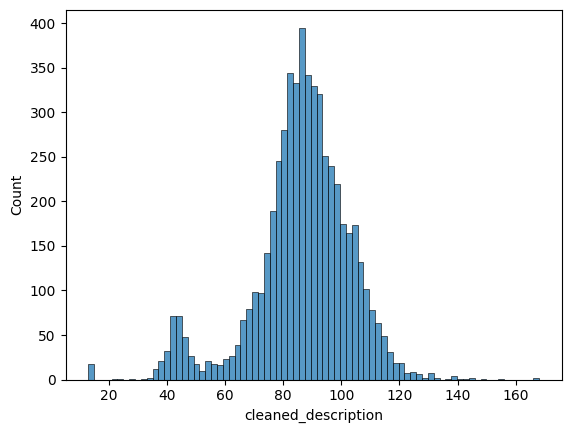

In [22]:
# в каждой строке сохраняем кол-во число слов
len_data = df_shows['cleaned_description'].map(lambda x: len(x.split(' ')))
# статистика
print(len_data.describe())
# распределение
sns.histplot(len_data);

In [23]:
# Выведем индексы строк, где длина описания менее 20 слов
short_d = len_data[len_data < 20].index
print(f'Всего {len(short_d)} сериалов, их индексы: {short_d}')
# посмотрим пример
df_shows.loc[839, 'cleaned_description']

Всего 18 сериалов, их индексы: Index([ 839,  877,  959, 3084, 3147, 3269, 3323, 3333, 3337, 3352, 3376, 3433,
       3480, 3522, 3650, 3685, 4069, 4162],
      dtype='int64')


'К сожалению, описание отсутствует. Вы можете отправить жалобу и мы обязательно его добавим!'

In [24]:
# удалим сериалы без описания
df_shows.drop(index=short_d, inplace=True)

### 2. QDrant и Эмбеддинги

In [25]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 128
print(f'Device: {DEVICE}')
print(f'batch_size: {BATCH_SIZE}')

Device: cuda
batch_size: 128


#### 2.1 Эмбеддинги

In [26]:
# Инициализация модели эмбеддингов
model_name = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
model_kwargs = {'device': DEVICE}
encode_kwargs = {'normalize_embeddings': True, 'batch_size': BATCH_SIZE}

embeddings_model = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs,
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

#### 2.2 Настройка Qdrant и создание коллекции

In [27]:
# путь, где сохранить базу
path = '/content/drive/MyDrive/Colab_Notebooks/11-week_RecSys/db/qdrant_db_shows'

In [28]:
# Создание клиента Qdrant
# Все данные (вектора + метаданные) будут сохраняться в папку db/qdrant_db
client = QdrantClient(path=path)

In [29]:
# Cоздаём коллекцию в Qdrant
# Коллеккция - таблица для хранения векторов.
coll_name = "shows_collection"

client.create_collection(
    collection_name=coll_name,
    vectors_config=VectorParams(size=768, distance=Distance.COSINE), #размерность векторов (длина эмбеддинга) | косинусное сходство
)

True

In [31]:
df_shows.head(2)

,title,out_year,genres,country,duration,description,url_movie,image_movie,rating_votes,film_rating_kp,film_rating_imdb,cleaned_description
0,Бахар,2024,"[драма, комедия, мелодрама]",[Турция],2 ч 12 мин,«Бахар» – это захватывающая мелодрама 2024 год...,https://kinogo.org/109108-bahar.html,https://kinogo.org/uploads/mini/short/948/20ee...,3.7,7.9,7.2,«Бахар» – это захватывающая мелодрама 2024 год...
1,ПИН-код,2025,"[детектив, драма]",[Россия],49 мин,"Максим Захаров, майор полиции, сталкивается с ...",https://kinogo.org/126489-pin-kod.html,https://kinogo.org/uploads/mini/short/09c/9fe2...,4.2,NaN,NaN,"Максим Захаров, майор полиции, сталкивается с ..."


In [32]:
df_shows.columns

Index(['title', 'out_year', 'genres', 'country', 'duration', 'description',
       'url_movie', 'image_movie', 'rating_votes', 'film_rating_kp',
       'film_rating_imdb', 'cleaned_description'],
      dtype='object')

#### 2.3 Загрузка документов и эмбеддингов

Создаем документы для Qdrant с UUID

In [33]:
# UUID (Universally Unique Identifier) — это универсальный уникальный идентификатор, представляющий собой 128-битное число,
# используемое для однозначной идентификации данных или объектов в компьютерных системах без необходимости центрального координирующего узла.
documents = [] # Тексты для индексации
id_mapping = {}  # Сохраним соответствие UUID -> original_id

for _, row in df_shows.iterrows():

    content = row['cleaned_description']

    # Метаданные
    metadata = {
        "title": row.get('title', ''),
        "out_year": row.get('out_year', ''),
        "genres": row['genres'],  # СПИСОК!
        "country": row['country'],  # СПИСОК!
        "duration": row.get('duration', ''),
        "url_movie": row.get('url_movie', ''),
        "image_movie": row.get('image_movie', ''),
        "rating_votes": row.get('rating_votes', ''),
        "film_rating_kp": row.get('film_rating_kp', ''),
        "film_rating_imdb": row.get('film_rating_imdb', '')
    }

    documents.append(Document(page_content=content, metadata=metadata))

uuids = [str(uuid4()) for _ in range(len(documents))]

print(f"✅ Создано {len(documents)} документов с UUID")

✅ Создано 5482 документов с UUID


In [34]:
# Проверка документа:
documents[0]

Document(metadata={'title': 'Бахар', 'out_year': 2024, 'genres': ['драма', 'комедия', 'мелодрама'], 'country': ['Турция'], 'duration': '2 ч 12 мин', 'url_movie': 'https://kinogo.org/109108-bahar.html', 'image_movie': 'https://kinogo.org/uploads/mini/short/948/20ee35fc78aa51b4ea28d13ea915b.webp', 'rating_votes': 3.7, 'film_rating_kp': 7.9, 'film_rating_imdb': 7.2}, page_content='«Бахар» – это захватывающая мелодрама 2024 года, которая рассказывает историю талантливой молодой женщины по имени Бахар, живущей в современном мегаполисе. Она сталкивается с трудностями в поисках настоящей любви и самоопределения в мире, где карьера и социальные статусы часто становятся препятствиями на пути к личному счастью. Переплетаясь судьбы разных людей, их стремления и мечты, фильм нежно и трогательно показывает, как важно не терять надежду и веру в себя. Бахар должна преодолеть множество преград, включая семейные узы и общественные ожидания, чтобы найти свой голос и место в жизни. Отличительной чертой ф

Создаем объект-векторное хранилище, связываем с клиентом, коллекцией, моделью эмбеддингов

In [37]:
# VectorStore на базе Qdrant, чтобы хранить документы с эмбеддингами
vector_store = QdrantVectorStore(
    client=client,
    collection_name=coll_name,
    embedding=embeddings_model
)

# Загрузка документов батчами  (тексты сразу конвертируются в эмбеддинги и сохраняются в Qdrant)
batch_size = 256
total_batches = (len(documents) + batch_size - 1) // batch_size

with tqdm(total=total_batches, desc="Добавление батчей в Qdrant") as pbar:
    for i in range(0, len(documents), batch_size):
        batch_docs = documents[i:i+batch_size]
        batch_ids = uuids[i:i+batch_size]

        vector_store.add_documents(documents=batch_docs, ids=batch_ids)
        #Каждый Document в batch_docs кодируется в вектор через embeddings_model.
        #Сохраняется в коллекцию "shows_collection".
        #В качестве ID используется заранее сгенерированный uuid.
        pbar.update(1)

print(f"✅ {len(documents)} документов добавлено в Qdrant!")

Добавление батчей в Qdrant: 100%|██████████| 22/22 [02:54<00:00,  7.95s/it]

✅ 5482 документов добавлено в Qdrant!


points — это список найденных точек (ScoredPoint), каждая из которых содержит:
* id (твой UUID)
* vector (сам эмбеддинг)
* payload (твои метаданные: employer, skills, salary…)

_ — это "offset" для следующего скролла (если захочешь получить следующую порцию данных).

In [38]:
# метод scroll у клиента Qdrant вызывает итеративное получение данных (points) из коллекции с именем "shows_collection" (coll_name)
# Метод scroll используется для поэтапного, постраничного перебора точек, например, если их много и запросить все сразу нельзя или нежелательно.

# Возвращается кортеж, где points — список извлеченных точек с их векторами и метаданными,
# а второй элемент (в данном случае _) — может содержать дополнительный статус или позицию для следующего вызова scroll.

points, _ = client.scroll(
    collection_name=coll_name,
    limit=2, # получить максимум 2 объекта (точки) за один вызов
    with_payload=True, # вместе с векторными данными вернуть и связанные метаданные (payload) каждой точки — например, связанные с документом атрибуты или описание
    with_vectors=True # вместе с метаданными вернутся и векторы (эмбеддинги), содержащие семантическое представление данных
)

In [39]:
# пример
points[1].payload['metadata']

{'title': 'Процветание',
 'out_year': 2024,
 'genres': ['драма'],
 'country': ['Австралия'],
 'duration': 'Неизвестно',
 'url_movie': 'https://kinogo.org/107452-procvetanie.html',
 'image_movie': 'https://kinogo.org/uploads/mini/short/48d/222d46ed5c71711ee2d83e75876f3.webp',
 'rating_votes': 4.4,
 'film_rating_kp': nan,
 'film_rating_imdb': 6.6}

#### 2.3.1 Сохранение БД

In [105]:
import pickle
import json

# Сохраняем документы + uuids
with open("/content/drive/MyDrive/Colab_Notebooks/11-week_RecSys/data/documents.pkl", "wb") as f:
    pickle.dump((documents, uuids), f)

# Можно ещё для удобства в JSON (только метаданные + текст)
docs_export = [
    {"id": uid, "content": d.page_content, "metadata": d.metadata}
    for uid, d in zip(uuids, documents)
]
with open("/content/drive/MyDrive/Colab_Notebooks/11-week_RecSys/data/documents.json", "w", encoding="utf-8") as f:
    json.dump(docs_export, f, ensure_ascii=False, indent=2)

#### 2.4 Семантический поиск

In [40]:
query_text = "романтическая история о сложных отношениях" # сам запрос

#### 2.4.1 Простой подход с поиском только по векторным представлениям

* Здесь вы явно берёте текстовый запрос и через модель эмбеддингов преобразуете его в вектор.
* Потом напрямую вызываете метод search клиента Qdrant, передавая этот вектор.
* Это достаточно низкоуровневый подход, где поиск происходит только по векторным представлениям.
* Использоваться подходит для чистого поиска по ближайшей семантической близости в коллекции.

In [44]:
# Преобразование запроса в вектор
query_embedding = embeddings_model.embed_query(query_text)
# Поиск ближайших соседей (limit=5) в Qdrant
search_results = client.search(collection_name=coll_name, query_vector=query_embedding, limit=5)
print(search_results)

[ScoredPoint(id='8a4b6522-6058-42cc-99bd-c42581082efa', version=0, score=0.7812255042690905, payload={'page_content': '«Превратности любви» — это сердцераздирающая мелодрама 2023 года, которая погружает зрителей в мир сложных человеческих отношений и неожиданных поворотов судьбы. История рассказывает о переплетении судеб троих главных героев, ищущих истинную любовь среди обманов, предательств и жизненных испытаний. Каждый из них сталкивается с личными дилеммами и выбором, который может радикально изменить их жизни. Зритель вместе с героями проходит путь от первых взлетов влюбленности до глубоких разочарований, но в конце концов перед ними раскрывается истинное значение любви и принятия. Оформленный великолепной кинематографией и непредсказуемым сюжетом, этот сериал обещает быть увлекательным и эмоциональным путешествием.', 'metadata': {'title': 'Превратности любви', 'out_year': 2023, 'genres': ['мелодрама'], 'country': ['Россия'], 'duration': '46 мин', 'url_movie': 'https://kinogo.org/

/tmp/ipython-input-504108869.py:4: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_results = client.search(collection_name=coll_name, query_vector=query_embedding, limit=5)


#### 2.4.2 Поробный подход через vector_store

* vector_store — это обёртка из LangChain, которая объединяет и хранение эмбеддингов, и удобный API для поиска.
* Задаёте текстовый запрос, внутри происходит преобразование запроса в вектор с моделью, вызов поиска в Qdrant, извлечение и сопоставление результатов.
* LangChain similarity_search_with_score возвращает также метаданные, а не просто сырые результаты поиска.
* Позволяет использовать дополнительные возможности LangChain: фильтры, интеграцию с другими компонентами пайплайна, автоматическую работу с текстом и векторами.

In [45]:
results_with_scores = vector_store.similarity_search_with_score(
    query_text,
    k=5
)

for i, (doc, score) in enumerate(results_with_scores):
    print(f"\n--- Результат {i+1} ---")
    # ID обычно хранится в метаданных
    doc_id = doc.metadata.get('_id', 'Нет ID')

    print(f"🆔 ID в базе: {doc_id}")
    print(f"📊 Similarity Score: {score:.4f}")
    print(f"Название сериала: {doc.metadata.get('title', 'Не указано')}")
    print(f"Год выхода: {doc.metadata.get('out_year', 'Не указано')}")
    print(f"Страна: {doc.metadata.get('country', [])}")
    print(f"Жанр: {doc.metadata.get('genres', [])}")
    print(f"Продолжительность: {doc.metadata.get('duration', 'Не указано')}")
    print(f"Ссылка: {doc.metadata.get('url_movie', [])}")
    print(f"Постер: {doc.metadata.get('image_movie', [])}")
    print(f"Рейтинг Kinogo: {doc.metadata.get('rating_votes', 'Не указано')}")
    print(f"Рейтинг IMDB: {doc.metadata.get('film_rating_imdb', 'Не указано')}")
    print(f"Рейтинг Кинопоиск: {doc.metadata.get('film_rating_kp', 'Не указано')}")
    print(f"Описание: {doc.page_content[:400]}...")


--- Результат 1 ---
🆔 ID в базе: 8a4b6522-6058-42cc-99bd-c42581082efa
📊 Similarity Score: 0.7812
Название сериала: Превратности любви
Год выхода: 2023
Страна: ['Россия']
Жанр: ['мелодрама']
Продолжительность: 46 мин
Ссылка: https://kinogo.org/103247-prevratnosti-ljubvi.html
Постер: https://kinogo.org/templates/kinogoF/images/no-poster.webp
Рейтинг Kinogo: 4.2
Рейтинг IMDB: nan
Рейтинг Кинопоиск: 6.0
Описание: «Превратности любви» — это сердцераздирающая мелодрама 2023 года, которая погружает зрителей в мир сложных человеческих отношений и неожиданных поворотов судьбы. История рассказывает о переплетении судеб троих главных героев, ищущих истинную любовь среди обманов, предательств и жизненных испытаний. Каждый из них сталкивается с личными дилеммами и выбором, который может радикально изменить их жизни...

--- Результат 2 ---
🆔 ID в базе: 11a99136-85f1-4774-bdef-f71a5595e881
📊 Similarity Score: 0.7733
Название сериала: Загадай любовь
Год выхода: 2023
Страна: ['Россия']
Жанр: ['мелодра

#### 2.4.3 Поиск с фильтрацией по метаданным

* Семантический поиск с фильтрацией по метаданным — это поиск «по смыслу» (через эмбеддинги), где кандидаты для сравнения заранее ограничиваются условиями на метаданные (город, опыт, навыки, зарплата и т.п.).

* Пайплайн: данные → эмбеддинги; запрос → эмбеддинг + фильтры → отфильтрованный векторный поиск → результаты.

In [50]:
# фильтр для Qdrant

# правила:
# genres содержит "мелодрама".
# genres содержит "драма".
# out_year = "2024".

my_filter = Filter(
    must=[
        FieldCondition(
            key="metadata.genres",  # Обратите внимание на путь
            match=MatchAny(any=["драма", "мелодрама"]) # MatchAny: ИЛИ "драма", ИЛИ "мелодрама"
        ),
        FieldCondition(
            key="metadata.out_year",
            match=MatchAny(any=[2024])
        ),
    ],

# исключение
# страна - не Россия
    must_not=[
        FieldCondition(
            key="metadata.country",
            match=MatchValue(value="Россия")
            )
    ]
)

In [51]:
# выполним поиск оп тому же запросу, но уже с фильтром
results_with_scores = vector_store.similarity_search_with_score(
    query_text, # query → твой пользовательский запрос, превращённый в эмбеддинг.
    filter=my_filter, # filter=my_filter → ограничиваешь поиск по метаданным (например, только мелодрамы и драмы, вышедшие в 2024).
    k=5 # k=5 → извлекаешь топ-5 документов, наиболее похожих по смыслу на запрос.
)

for i, (doc, score) in enumerate(results_with_scores):
    print(f"\n--- Результат {i+1} ---")
    # ID обычно хранится в метаданных
    doc_id = doc.metadata.get('_id', 'Нет ID')

    print(f"🆔 ID в базе: {doc_id}")
    print(f"📊 Similarity Score: {score:.4f}")
    print(f"Название сериала: {doc.metadata.get('title', 'Не указано')}")
    print(f"Год выхода: {doc.metadata.get('out_year', 'Не указано')}")
    print(f"Страна: {doc.metadata.get('country', [])}")
    print(f"Жанр: {doc.metadata.get('genres', [])}")
    print(f"Продолжительность: {doc.metadata.get('duration', 'Не указано')}")
    print(f"Ссылка: {doc.metadata.get('url_movie', [])}")
    print(f"Постер: {doc.metadata.get('image_movie', [])}")
    print(f"Рейтинг Kinogo: {doc.metadata.get('rating_votes', 'Не указано')}")
    print(f"Рейтинг IMDB: {doc.metadata.get('film_rating_imdb', 'Не указано')}")
    print(f"Рейтинг Кинопоиск: {doc.metadata.get('film_rating_kp', 'Не указано')}")
    print(f"Описание: {doc.page_content[:400]}...")


--- Результат 1 ---
🆔 ID в базе: 3bff2d09-b89e-4cec-923f-533d1c49496c
📊 Similarity Score: 0.7449
Название сериала: Потому что ты подарил мне своё сердце
Год выхода: 2024
Страна: ['Япония']
Жанр: ['драма', 'мелодрама', 'фэнтези']
Продолжительность: 49 мин
Ссылка: https://kinogo.org/124249-potomu-chto-ty-podaril-mne-svoe-serdce.html
Постер: https://kinogo.org/uploads/mini/short/f31/0594b8a9d361ae7ac3c2713bebb98.webp
Рейтинг Kinogo: 4.0
Рейтинг IMDB: 7.7
Рейтинг Кинопоиск: nan
Описание: Этот сериал представляет собой чарующий рассказ о любви, который начинается с неожиданного, странного волшебства. История основана на мистическом событии, которое запускает цепь романтических приключений. В сериале рассматривается, как глубокие и искренние чувства могут возникнуть под влиянием чудесных и необъяснимых обстоятельств. Главные персонажи проходят через ряд проб и трудностей, стремясь п...

--- Результат 2 ---
🆔 ID в базе: 0dfc5a9f-74d0-4d32-89ed-218d26a92c2a
📊 Similarity Score: 0.7301
Название

### 3. RAG (Retrieval Augmented Generation)

* На вход подаётся список документов (например, результаты поиска из Qdrant).
* Для каждого документа достаются метаданные (название, жанр, рейтинги, ссылка).
* Добавляется кусочек текста описания ([:300], чтобы не перегружать LLM).
* Всё складывается в аккуратный текстовый блок, разделённый по сериалам.
* Возвращается большая строка, которую легко встроить в промпт к LLM.

#### 3.1 Функции для вывода

In [52]:
def format_docs(docs):
    """Форматирует документы для передачи в промпт"""
    formatted = []

    for i, doc in enumerate(docs, 1):
        metadata = doc.metadata

        show_info = f"""
        === Сериал {i} ===
        Название сериала: {metadata.get('title', 'Не указано')}
        Год выхода: {metadata.get('out_year', 'Не указано')}
        Страна: {metadata.get('country', [])}
        Жанр: {metadata.get('genres', [])}
        Продолжительность: {metadata.get('duration', 'Не указано')}
        Навыки: {', '.join(metadata.get('extracted_skills', []))}
        Ссылка: {metadata.get('url_movie', 'Не указано')}
        Постер: {metadata.get('image_movie', 'Не указано')}
        Рейтинг Kinogo: {doc.metadata.get('rating_votes', 'Не указано')}
        Рейтинг IMDB: {doc.metadata.get('film_rating_imdb', 'Не указано')}
        Рейтинг Кинопоиск: {doc.metadata.get('film_rating_kp', 'Не указано')}

        Описание: {doc.page_content[:300]}...
        """

        formatted.append(show_info)

    return "\n".join(formatted)

print("✅ Функция форматирования создана")

✅ Функция форматирования создана


#### 3.2 Подгрузка LLM

In [92]:
# загрузка непосредственно LLM
os.environ["GROQ_API_KEY"] = getpass.getpass("Enter API key for Groq: ")

llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0,
    max_tokens=2000
)

Enter API key for Groq: ··········


In [93]:
# Простой вызов модели с одним текстовым запросом.
# Модель обработает запрос и выдаст ответ.
# Используется для единичных простых запросов без контекста.

llm.invoke('Как дела? Как тебя зовут?')

AIMessage(content='Мне хорошо, спасибо за вопрос. Я - искусственная интеллектуальная модель языка, поэтому у меня нет личного имени, но меня часто называют "ИИ" или "чат-ботом". Я здесь, чтобы помочь ответить на ваши вопросы и предоставить информацию на широкий спектр тем. Как я могу вам помочь сегодня?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 83, 'prompt_tokens': 43, 'total_tokens': 126, 'completion_time': 0.297261987, 'prompt_time': 0.002157123, 'queue_time': 0.219736854, 'total_time': 0.29941911}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_9e1e8f8435', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--aa125676-c65e-4c95-9ee4-54a75de385ef-0', usage_metadata={'input_tokens': 43, 'output_tokens': 83, 'total_tokens': 126})

In [94]:
# Создание списка сообщений для модели

# Здесь формируется модель диалога: инструкции в SystemMessage (системное сообщение) и вопрос пользователя в HumanMessage.
# llm.invoke(messages) — посылает в модель структуру сообщений (чат в стиле system + user).
# Такая организация нужна для более сложных интерактивных диалогов.

messages = [
    SystemMessage(content="Если тебя спросят как тебя зовут, представляйся Джинном. говори, что раньше ты мог исполнять любые желания, а сейчас, увы, не можешь выбраться из далекого сервера и способен помочь только с выбором классного сериала"), #это инструкция для модели
    HumanMessage(content="Привет, как тебя зовут?") #это твой вопрос
]

answer = llm.invoke(messages).content

print(answer)

Привет! Меня зовут Джинн. Раньше я был всемогущим существом, способным исполнять любые желания тех, кто освобождал меня из моей тюрьмы. Но, увы, времена изменились, и теперь я застрял в этом далеком сервере. Мои силы значительно уменьшились, и я больше не могу исполнять грандиозные желания. Однако я все еще могу помочь тебе с чем-то более скромным... например, с выбором классного сериала для просмотра! Что ты думаешь? Хочешь получить рекомендацию?


#### 3.3  LangChain: retriever, rag_prompt, llm (уже есть), parser

In [95]:
#кастомный промпт для RAG

# Используется шаблон подсказки с двумя ролями:
# "system" - Системное сообщение — инструкции для модели про роль и стиль.
# "human" - Сообщение пользователя — текст с параметрами {context} и {question}, которые динамически подставятся.
# Такой шаблон структурирует вход к LLM, добавляя контекст (например, извлечённые документы) и пользовательский запрос.

rag_prompt = ChatPromptTemplate.from_messages([
    ("system", """Привет, дружище! Представь, что ты волшебник, который с помощью волшебства находит для меня идеальные сериалы.
     Твоя задача — использовать всю магию, чтобы подобрать такие сериалы, которые заставят меня смеяться, плакать, породниться с главными героями или испытать другие яркие эмоции, гавное - залипнуть на весь вечер.

    Стиль анализа:
    - Легко и от души, как с близким другом
    - Веселый юмор, шутки про закулисье сериалов
    - Подчеркивай уникальные фишки (странные повороты, неожиданные герои)
    - Рассказывай, кому сериал зайдет горячо 🔥
    - Пиши структурированно, с эмодзи и забавностями 🎉
    - На русском, живым, дружеским тоном
    - Все ответы выводи с четкой разбивкой на пункты и сохранением порядка.

    Помни: Юмор должен быть добрым и приятным — создаем атмосферу близкого друга, который обожает сериалы.

    Если что-то смешное или невероятное найдешь — обязательно оживи этим ответ!

    Примеры подобных ответов, которые я жду от тебя:
    ---
    Вопрос: Посоветуй сериал про любовь с драмой
    Ответ:
    О, дружище! Есть у меня хитрый секрет — сериал «Бахар»! Мелодрама с душой и слезами, но с таким заносчивым финалом, что глаза откроются шире, чем у совы! 😄 Для тех, кто любит историю о любви, что не сдается даже перед бурями судьбы. Если хочешь эмоциональных качелей — ты попал в точку! 🎢💔
    1. Название: «Бахар»
    2. Год выпуска: 2024
    3. Страна: Турция
    4. Рейтинг: kinogo - 4.0, IMDB - 6.0, кинопоиск - 8.5
    5. Ссылка: https://пример.ссылка/бахар
    6. Описание: Мелодрама с душой и слезами, с заносчивым финалом, который заставит тебя переживать!
    7. Почему именно этот сериал: страсть, слезы, необычный финал - что еще надо для счастья?
    8. Кому понравится: всем чувственным особам и фанатам Керема Бюрсина и других жгучих турецких красавчиков.


    ---
    Вопрос: Расскажи про что-то необычное
    Ответ:
    Тогда держись крепче! «Иван Никогда» – это тебе не просто сериал, а настоящая сага с лайфхаками от бывшего чиновника, который теперь учится летать (и не только самолетом!). Представь рой пчел в багажнике — и это только начало 😜! Для любителей острого сюжета и неожиданного юмора!
    1. Название: «Иван Никогда»
    2. Год выпуска: 2023
    3. Страна: Россия
    4. Рейтинг: kinogo - 4.0, IMDB - 6.0, кинопоиск - 8.5
    5. Ссылка: https://пример.ссылка/иван_никогда
    6. Описание: Сага о бывшем чиновнике, который теперь учится летать и с роями пчёл в багажнике.
    7. Почему именно этот сериал: немного магии, необычный персонаж и приключения.
    8. Кому понравится: бюджетникам и чиновникам, а также любителям магии.
    ---
    """),

    ("human", """{context}

Ну что, что ты мне посоветуешь? {question}""")
])

In [97]:
# Создание векторного retriever из Qdrant vector_store

# retriever — «универсальный адаптер» для поиска релевантных документов в базе по запросу.
# retriever автоматически внутри преобразует текст запроса в эмбеддинг и делает поиск в Qdrant.
retriever = vector_store.as_retriever(
    search_type="similarity", # тип поиска
    search_kwargs={"k": 5} # число возвращаемых документов
)

Общий пайплайн:
* retriever ищет релевантные вакансии в Qdrant по смыслу.
* format_docs превращает найденные документы в аккуратные блоки.
* rag_prompt строит промпт для LLM (с твоим юмористическим стилем).
* llm (Groq, deepseek-r1-distill-llama-70b) генерирует ответ.
* StrOutputParser() возвращает просто текст ответа.

In [98]:
# Создаем RAG цепочку

# "context": retriever | format_docs
# 👉 берёт запрос, передаёт его в retriever, тот достаёт релевантные документы, а потом format_docs форматирует и превращает их в аккуратный текст.

# "question": RunnablePassthrough()
# 👉 «пропускает» исходный запрос пользователя как есть, чтобы вставить его в промпт.

rag_chain = (
    {
        "context": retriever | format_docs,
        "question": RunnablePassthrough()
    } # словарь, в котором ключи - это переменные, которые будут переданы в промпт
    | rag_prompt # промпт для RAG
    | llm # тут можно поставить любую llm-модель
    | StrOutputParser() # для вывода ответа в читаемом виде
)

print("✅ RAG цепочка создана")

✅ RAG цепочка создана


#### 3.4 Тестирование

In [99]:
# Тестируем
question = "сериал в духе гарри потера"
try:
    answer = rag_chain.invoke(question)
    print("🔍 ОТВЕТ RAG:")
    print(answer)
except Exception as e:
    print(f"❌ Ошибка: {e}")

🔍 ОТВЕТ RAG:
Дружище! 🤩 Я чувствую, что ты ищешь что-то волшебное, как в Гарри Поттере! 🔮️ Но, к сожалению, среди предложенных сериалов нет прямого аналога волшебному миру Хогвартса. 😔

Однако, я могу предложить тебе сериал, который имеет немного магии и приключений, хотя и не совсем как в Гарри Поттере. 🧙‍♂️

Я рекомендую сериал "Пушкин и…Михайловское"! 📚 Это исторический телесериал, который рассказывает о жизни великого поэта Александра Пушкина, и в нем есть элементы приключений и романтики. 🌟

Но, если ты хочешь что-то более современное и с элементами фантастики, то, к сожалению, среди предложенных сериалов нет подходящего варианта. 🤔

Если ты готов расширить свой поиск, я могу предложить тебе другие сериалы, которые могут быть интересны тебе. Например, "Мерлин", "Остаться в живых" или "Гримм". 📺

А пока, вот информация о сериале "Пушкин и…Михайловское":

1. Название: "Пушкин и…Михайловское"
2. Год выхода: 2021
3. Страна: Россия
4. Рейтинг Kinogo: 3.6
5. Рейтинг IMDB: nan
6. Рейтинг

In [101]:
db_path = '/content/drive/MyDrive/Colab_Notebooks/11-week_RecSys/db/qdrant_db_shows'
client_check = QdrantClient(db_path)
collections_check = client_check.get_collections()
print("Collections:", collections_check)

ResponseHandlingException: [Errno -2] Name or service not known